In [3]:
"""
Imports needed

Several .py required to be in same folder as notebook:
ceda_download.py, cross_wavelet.py, distance_matrix.py, download_midas_data.py, july21_get_all_data.py,
july21_get_cosmos_data.py, july_21_get_flux_data.py, july21_get_midas_data.py, rf.py
"""
from download_midas_data import download_midas_full
from july21_get_all_data import get_july21_all_data
from sklearn import preprocessing
from cross_wavelet import cross_wavelet
from distance_matrix import *
from rf import plot_cols_4_cols_importances, plot_combi_summed_importances, plot_n_groups_importances

In [ ]:
"""
Run this cell to download MIDAS Data for 2021. The files are saved in the correct file structure for the next cell.

NOTE: A CEDA account with access to the full MIDAS datset is required to run this cell
"""
download_midas_full([2021],'Hanger Field July 2021/MIDAS Data', daily_rain=False)

In [4]:
"""
Run this cell to create a dataframe of MIDAS, COSMOS, and flux data for Spen Farm, Hanger Field, July 2021 sampled at
30min intervals.

Raw data files must be in the following file structure in the same directory as the notebook .ipynb:

Hanger Field July 2021/MIDAS Temperature Data/Soil/midas_soiltemp_202101-202112.txt
Hanger Field July 2021/MIDAS Temperature Data/Air/midas_tempdrnl_202101-202112.txt
Hanger Field July 2021/MIDAS Rain Data/Hourly/midas_rainhrly_202101-202112.txt
Hanger Field July 2021/MIDAS Solar Data/midas_radtob_202101-202112.txt
Hanger Field July 2021/MIDAS Wind Data/midas_wind_202101-202112.txt
Hanger Field July 2021/COSMOS Data/COSMOS and Hanger Field Data July 2021.csv
Hanger Field July 2021/Flux Data/ July_flux_data_HF.csv

Replace this cell with code creating own dataframe called 'df' to use the subsequent methods on alternate data.
"""
# creates dataframe
df = get_july21_all_data('interp')

# prints dataframe columns so user can see them for selection in next cell
print(df.columns)

D:\NERC REP 21\NERC REP Repo\NERC-REP\venv\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


Index(['q10cm_soil_temp', 'max_air_temp', 'min_air_temp', 'min_grss_temp',
       'min_conc_temp', 'prcp_amt', 'glbl_irad_amt', 'mean_wind_dir',
       'mean_wind_speed', 'max_gust_dir', 'max_gust_speed', 'Tau', 'H', 'LE',
       'co2_flux', 'h2o_flux', 'PRECIPITATION_LEVEL2', 'Q_LEVEL2', 'RH_LEVEL2',
       'TA_LEVEL2', 'PA_LEVEL2', 'LWIN_LEVEL2', 'SWIN_LEVEL2', 'LWOUT_LEVEL2',
       'SWOUT_LEVEL2', 'RN_LEVEL2', 'WD_LEVEL2', 'WS_LEVEL2', 'COSMOS_VWC',
       'D86_75M', 'G1_LEVEL2', 'G2_LEVEL2', 'STP_TSOIL2_LEVEL2',
       'STP_TSOIL5_LEVEL2', 'STP_TSOIL10_LEVEL2', 'STP_TSOIL20_LEVEL2',
       'STP_TSOIL50_LEVEL2', 'TDT1_TSOIL_LEVEL2', 'TDT2_TSOIL_LEVEL2',
       'TDT1_VWC_LEVEL2', 'TDT2_VWC_LEVEL2', 'Unnamed: 27'],
      dtype='object')


In [5]:
"""
Run this cell to normalise df

This cell is needed for the distance matrix and random forest cells later.
"""
x = df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normed_df = pd.DataFrame(x_scaled, columns=df.columns)

In [ ]:
"""
Run this cell to perform cross-wavelet analysis on two of the columns of 'df'

Plots are generate of:
-Both columns against time
-Wavelet power spectrum of each column
-Cross-wavelet power spectrum
-Cross-wavelet coherence

NOTE: If using an alternate dataframe, the columns must have the same length.
"""
# Changes index from datetime to numeric [1,2,3,...]
df = df.reset_index(level=0)

# Selects dataframe columns to use
col1 = 'COSMOS_VWC'
col2 = 'co2_flux'

"""
Performs and plots cross-wavelet analysis for col1 and col2

:param df: dataframe, index should be in time order
:param col1: Column name of df
:param col2: Column name of df
:param x_skip: Spread of phase arrows in x direction
:param y_skip: Spread of phase arrows in y direction
:param y_lim: y limit of correlation plot
:param box_pdf_s1: Bool to change PDF of col1, good for highly bi-modal data
:param box_pdf_s2: Bool to change PDF of col2, good for highly bi-modal data
:param cache: Bool to cache significance, makes subsequent runs of code for same time series faster
"""
cross_wavelet(df, col1, col2, x_skip=20, y_skip=5, y_lim=400, box_pdf_s1=False, box_pdf_s2=False, cache=False)

100%|██████████| 42/42 [00:25<00:00,  1.63it/s]


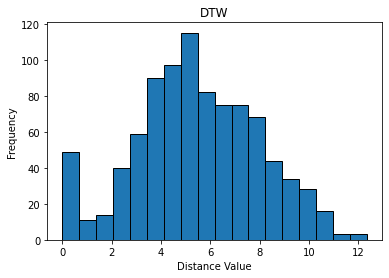

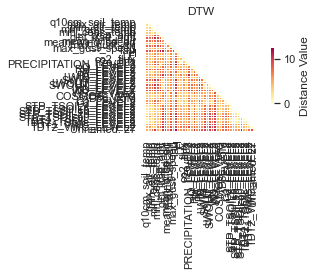

Threshold Num Groups: 100%|██████████| 862/862 [00:00<00:00, 1146.74it/s]


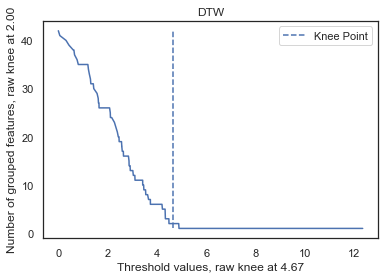

D:\NERC REP 21\NERC REP Repo\NERC-REP\distance_matrix.py:270: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


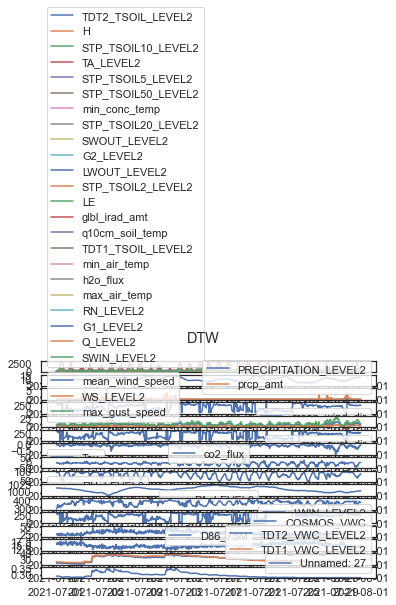

In [6]:
"""
Run this cell to calculate and plot a distance matrix for df using DTW
Plot generated:
-Heatmap of distance matrix
-Distribution of distance values in distance matrix
-Number of groups against threshold distance values
-Grouped features against time for a chosen number of groups
"""
# Calculates distance matrix and plots heatmap and distribution plots
dtw_mat = distMatrix(normed_df,calcDTWDist)
graphMatrixDistribution(dtw_mat['fullMatrix'],title='DTW')
graphMatrixHeatmap(dtw_mat, title = 'DTW')

# Plots number of groups against threshold values
xs, ys = getThresholdandNumFeaturesLeft(dtw_mat['fullMatrix'])
kn = findKneePoint(xs, ys)
graphThresholdValues(xs, ys, kneePoint=kn,title='DTW')

# Groups columns with threshold = threshold and plots groups, example uses threshold = 2.7 but this value can be changed
featureGrouping = compressMatrixValues(dtw_mat['fullMatrix'], dtw_mat['fullList'], threshold=2.7)
graphFeatureGroupsSubplots(df,featureGrouping,title = 'DTW')

In [ ]:
"""
Run this cell to calculate and plot a distance matrix for df using Pearson's correlation coefficient
Plot generated:
-Heatmap of distance matrix
-Distribution of distance values in distance matrix
-Number of groups against threshold distance values
-Grouped features against time for a chosen number of groups
"""
# Calculates distance matrix and plots heatmap and distribution plots
pear_mat = distMatrix(normed_df,pearson)
graphMatrixDistribution(pear_mat['fullMatrix'],title='Pearson')
graphMatrixHeatmap(pear_mat, title = 'Pearson')

# Plots number of groups against threshold values
xs, ys = getThresholdandNumFeaturesLeft(pear_mat['fullMatrix'])
kn = findKneePoint(xs, ys)
graphThresholdValues(xs, ys, kneePoint=kn,title='Pearson')

# Groups columns with threshold = threshold and plots groups, example uses threshold = 0.1 but this value can be changed
featureGrouping = compressMatrixValues(pear_mat['fullMatrix'], pear_mat['fullList'], threshold=0.1)
graphFeatureGroupsSubplots(df,featureGrouping,title = 'Pearson')

In [ ]:
"""
Run this cell to calculate and plot a distance matrix for df using Spearman's rank correlation coefficient
Plot generated:
-Heatmap of distance matrix
-Distribution of distance values in distance matrix
-Number of groups against threshold distance values
-Grouped features against time for a chosen number of groups
"""
# Calculates distance matrix and plots heatmap and distribution plots
spear_mat = distMatrix(normed_df,calcDTWDist)
graphMatrixDistribution(spear_mat['fullMatrix'],title='Spearman')
graphMatrixHeatmap(dtw_mat, title = 'Spearman')

# Plots number of groups against threshold values
xs, ys = getThresholdandNumFeaturesLeft(spear_mat['fullMatrix'])
kn = findKneePoint(xs, ys)
graphThresholdValues(xs, ys, kneePoint=kn,title='Spearman')

# Groups columns with threshold = threshold and plots groups, example uses threshold = 0.1 but this value can be changed
featureGrouping = compressMatrixValues(spear_mat['fullMatrix'], spear_mat['fullList'], threshold=0.1)
graphFeatureGroupsSubplots(df,featureGrouping,title = 'Spearman')
